In [1]:
### Imports for pytorch

import torch
from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4MConvZ2, P4MConvP4M, P4ConvZ2, P4ConvP4

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from RotMNIST import RotMNIST


C:\Users\Jack\anaconda3\envs\reu-code\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Rotated sample
Feature batch shape: torch.Size([64, 1, 32, 32])
torch.Size([64])
Labels batch shape: torch.Size([64])


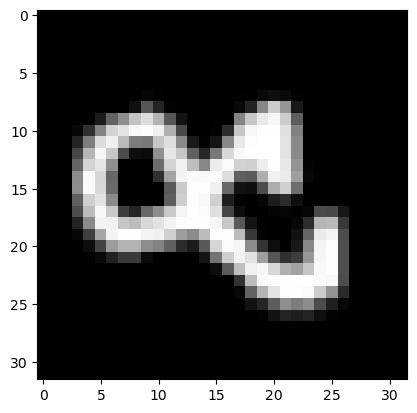

Label: 8
Upright sample
Feature batch shape: torch.Size([64, 1, 32, 32])
Labels batch shape: torch.Size([64])


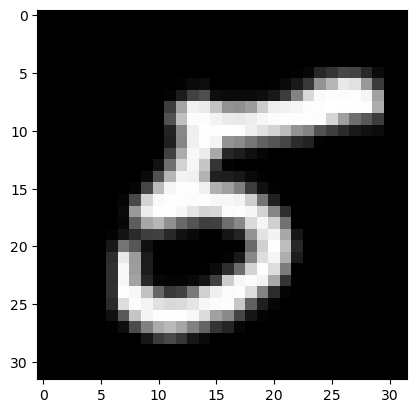

Label: 5


In [2]:
### Instatiate RotMNIST and verify behaviour below with the dataloaders
dataset_rot = RotMNIST(
    root = 'data',
    download=True,
    train=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),
    rotation_mirroring=True
)

test_dataset_rot = RotMNIST(
    root = 'data',
    download=True,
    train=False,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),
    rotation_mirroring=True
)

dataset_upright = RotMNIST(
    root = 'data',
    download=True,
    train=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]
    ),
    rotation_mirroring=False,
)

### Instantiate dataloader for RotMNIST and get batches
train_dataloader_rot = DataLoader(dataset_rot, batch_size=64, shuffle=True)
test_dataloader_rot = DataLoader(test_dataset_rot, batch_size=64, shuffle=True)
train_dataloader_upright = DataLoader(dataset_upright, batch_size=64, shuffle=True)

## Images from rotated dataset
print("Rotated sample")
train_features_rot, train_labels_rot = next(iter(train_dataloader_rot))
print(f"Feature batch shape: {train_features_rot.size()}")
print(train_labels_rot.size())
print(f"Labels batch shape: {train_labels_rot.size()}")
img = train_features_rot[0].squeeze()
label = train_labels_rot[0]
img.shape
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Images from non-rotated dataset
print("Upright sample")
train_features, train_labels = next(iter(train_dataloader_upright))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img.shape
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")


In [3]:
import torch.nn as nn
import torch.nn.functional as F

# Define max pooling as from COGNAR

import torch.nn.functional as F

def plane_group_spatial_max_pooling(x, ksize, stride=None, pad=0):
    xs = x.size()
    x = x.view(xs[0], xs[1] * xs[2], xs[3], xs[4])
    x = F.max_pool2d(input=x, kernel_size=ksize, stride=stride, padding=pad)
    x = x.view(xs[0], xs[1], xs[2], x.size()[2], x.size()[3])
    return x

In [4]:
### G-Conv p4m training, 


# Three settings for convolutional layers:
#   * self.conv1 = P4MConvZ2(in_channels=1, out_channels=2, kernel_size=5, stride=1),   self.conv2 = P4MConvP4M(in_channels=2, out_channels=4, kernel_size=5, stride=1)
#   * self.conv1 = P4ConvZ2(in_channels=1, out_channels=4, kernel_size=5, stride=1),    self.conv2 = P4ConvP4(in_channels=4, out_channels=6, kernel_size=5, stride=1)
#   * self.conv1 = nn.Conv2d(1, 6, 5), self.conv2 = nn.Conv2d(6, 16, 5)

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__() 
        # self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv1 = P4MConvZ2(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        # self.pool = nn.MaxPool2d(2, 2) - getting replaced by plane_group_max_pooling
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2 = P4MConvP4M(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        self.conv3 = P4MConvP4M(in_channels=16, out_channels=32, kernel_size=5)

        self.fc1 = nn.Linear(32, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = plane_group_spatial_max_pooling(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = plane_group_spatial_max_pooling(x, 1, 1)
        x = torch.max(x, dim=2)[0]
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

net = Net()


print(net)
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable params: " + str(pytorch_total_params))

Net(
  (conv1): P4MConvZ2()
  (conv2): P4MConvP4M()
  (conv3): P4MConvP4M()
  (fc1): Linear(in_features=32, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)
Number of trainable params: 122244


In [5]:
### Hyper-parameters

learning_rate = 0.001
batch_size = 64
epochs = 100

### Optimizers, Objectives 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [6]:
### Training and testing function definitions

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        
        # Compute prediction and loss for backprop
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation by setting grad to zero, calculating using backprop engine and stepping (using learning rate)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    # No gradient on training data (faster computation and no optimization happening here anyway)
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            correct += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader_upright, net, loss_fn, optimizer)

    # Test loop will always have testing done with rotations and scaling
    test_loop(test_dataloader_rot, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
torch.Size([64, 32, 1, 1])
loss: 2.292223  [    0/60000]
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([64, 32, 1, 1])
torch.Size([

KeyboardInterrupt: 

In [8]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader_rot:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on %i test images: %f %%' % (total, 100.0 * correct / total))

Accuracy of the network on 10000 test images: 95.310000 %
